https://m.blog.naver.com/PostView.nhn?blogId=dnjswns2280&logNo=222028246343&proxyReferer=https:%2F%2Fwww.google.com%2F

In [9]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys

plt.style.use('dark_background')

In [10]:
pwd

'E:\\Users\\inje\\교육\\202012_국비지원 IT교육\\SideProj.-Mask_Detection\\model\\BbangBro'

In [11]:
%cd "E:\Users\inje\교육\202012_국비지원 IT교육\mask_detection"

[WinError 2] 지정된 파일을 찾을 수 없습니다: 'E:\\Users\\inje\\교육\\202012_국비지원 IT교육\\mask_detection'
E:\Users\inje\교육\202012_국비지원 IT교육\SideProj.-Mask_Detection\model\BbangBro


In [12]:
r'E:\Users\inje\교육\202012_국비지원 IT교육\SideProj.-Mask_Detection\model\BbangBro\models\after_transfer_learning'#.replace('\\', '/')

'E:\\Users\\inje\\교육\\202012_국비지원 IT교육\\SideProj.-Mask_Detection\\model\\BbangBro\\models\\after_transfer_learning'

In [13]:
# facenet: 얼굴 인식 모델
facenet = cv2.dnn.readNet('./models/deploy.prototxt',
                          './models/res10_300x300_ssd_iter_140000.caffemodel')
# model: 마스크 검출 모델
# model = load_model('./models/mask_detector.model')
model = load_model('E:\\Users\\inje\\교육\\202012_국비지원 IT교육\\SideProj.-Mask_Detection\\model\\BbangBro\\models\\after_transfer_learning'
)

In [14]:
img = cv2.imread('./003880_1.jpg')

plt.figure(figsize=(10,10))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()
print(img.shape)

TypeError: 'NoneType' object is not subscriptable

<Figure size 720x720 with 0 Axes>

###  Preprocess Image for Face Detection

In [7]:
# 이미지 높이, 너비 추출
h, w = img.shape[:2]

blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=(104.,177.,123.))

# facenet의 input으로 blob을 설정
facenet.setInput(blob)
# facenet 결과 추론, 얼굴 추출 결과가 dets에 저장
dets = facenet.forward()

# 이미지 내의 여러 얼굴들을 받음
result_img = img.copy()

### Detect Faces

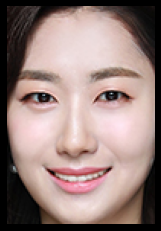

In [8]:
faces = []

for i in range(dets.shape[2]):
    # 검출한 결과가 신뢰도
    confidence = dets[0, 0, i, 2]
    # 신뢰도를 0.5로 임계치 지정
    if confidence < 0.5:
        continue
        
    x1 = int(dets[0, 0, i, 3] * w)
    y1 = int(dets[0 ,0, i, 4] * h)
    x2 = int(dets[0 ,0, i, 5] * w)
    y2 = int(dets[0 ,0, i, 6] * h)

    # 원본 이미지에서 얼굴영역 추출
    face = img[y1:y2, x1:x2]
    faces.append(face)

    
for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:,:,::-1])
    plt.axis('off')
    

###  Detect Masks from Faces

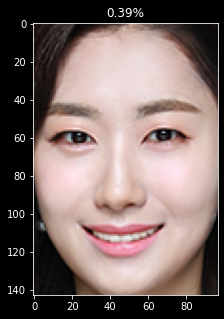

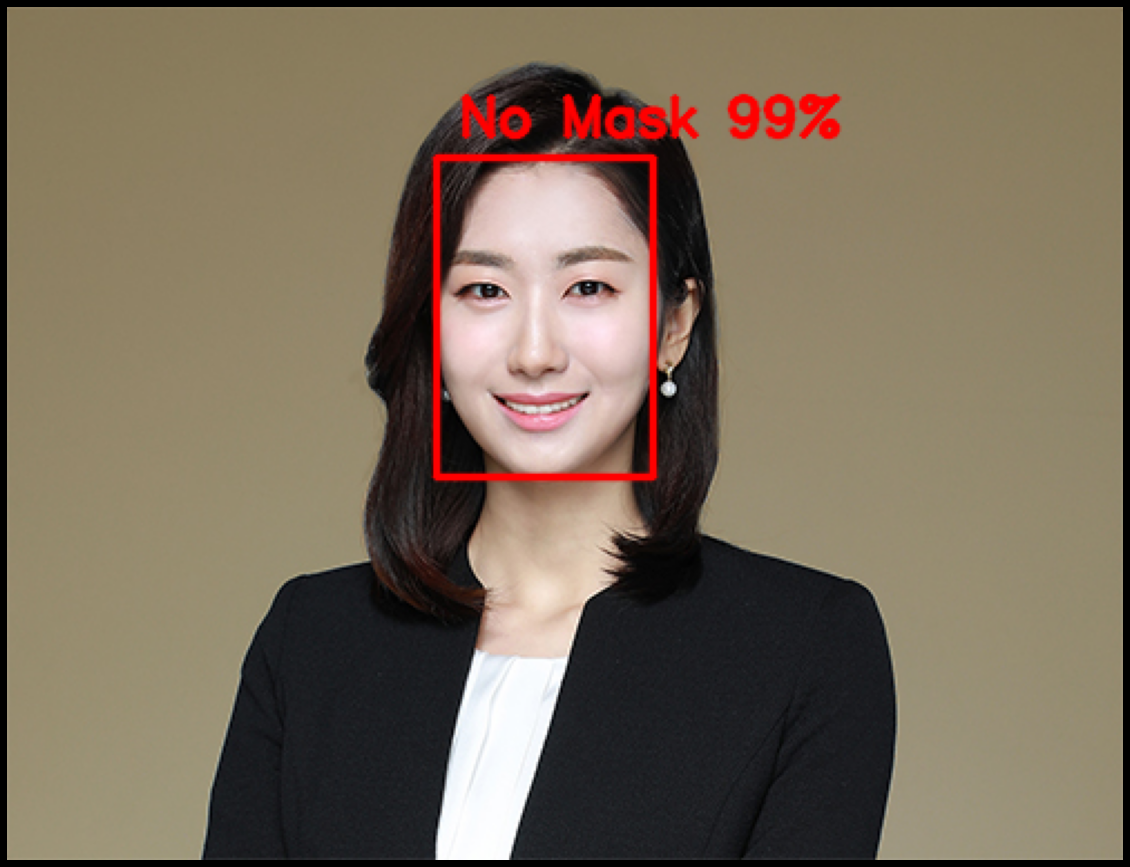

In [9]:
plt.figure(figsize=(16,5))

for i, face in enumerate(faces):
    # 추출한 얼굴영역을 전처리
    face_input = cv2.resize(face, dsize=(224,224))
    face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
    face_input = preprocess_input(face_input)
    face_input = face_input[np.newaxis, ...]

    # 마스크 검출 모델로 결과값 return
    mask, nomask = model.predict(face_input).squeeze()
    
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:,:,::-1])
    plt.title('%.2f%%' % (mask * 100))
    
    # 마스크 착용여부에 따라 라벨링
    if mask > nomask:
        color = (0, 255, 0)
        label = 'Mask %d%%' % (mask * 100)
    else:
        color = (0, 0, 255)
        label = 'No Mask %d%%' % (nomask * 100)

# 화면에 얼굴위치와 마스크 유무를 출력
cv2.rectangle(result_img, pt1=(x1,y1), pt2=(x2,y2), thickness=2, color=color, lineType=cv2.LINE_AA)
cv2.putText(result_img, text=label, org=(x1+10,y1-10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=.8,
            color=color, thickness=2, lineType=cv2.LINE_AA)

plt.figure(figsize=(20,20))
plt.imshow(result_img[:,:,::-1])
plt.axis('off')
plt.show()

### Mask Detection with Webcam Connect

In [ ]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("웹캠 연결실패")
    exit(1)
    
ret, img = cap.read()
if not ret:
    print("캡처 실패")
    exit(1)
    
print(img.shape)
height, width = img.shape[0], img.shape[1]
fps = cap.get(cv2.CAP_PROP_FPS)
delay = int(np.round(1000/fps))
codec = cv2.VideoWriter_fourcc(*"MJPG")

RESULT_DIR = 'output'
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)
filename = "webcam_output.avi"
file_path = os.path.join(RESULT_DIR, filename)
    
writer = cv2.VideoWriter(file_path, codec, fps, (width, height))
if not writer.isOpened():
    print("동영상파일로 출력할 수 없습니다.")
    exit(1)

while True:
    ret, img = cap.read()
    if not ret:
        print("캡쳐 실패")
        break
    img = cv2.flip(img, 1)
    
    result_img = detect_show_mask(img)
    
    writer.write(result_img)
    cv2.imshow('frame', result_img)
    
    if cv2.waitKey(delay) == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

(480, 640, 3)


In [16]:
def detect_show_mask(img):
    h, w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=(104.,177.,123.))
    facenet.setInput(blob)
    dets = facenet.forward()
    result_img = img.copy()

    faces = []

    for i in range(dets.shape[2]):
        confidence = dets[0, 0, i, 2]
        if confidence < 0.5:
            continue
        x1 = int(dets[0, 0, i, 3] * w)
        y1 = int(dets[0 ,0, i, 4] * h)
        x2 = int(dets[0 ,0, i, 5] * w)
        y2 = int(dets[0 ,0, i, 6] * h)
        face = img[y1:y2, x1:x2]
        
        face_input = cv2.resize(face, dsize=(224,224))
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
        face_input = preprocess_input(face_input)
        face_input = face_input[np.newaxis, ...]

        mask, nomask = model.predict(face_input).squeeze()
        if mask > nomask:
            color = (0, 255, 0)
            label = 'Mask %d%%' % (mask * 100)
        else:
            color = (0, 0, 255)
            label = 'No Mask %d%%' % (nomask * 100)
            
        cv2.rectangle(result_img, pt1=(x1,y1), pt2=(x2,y2), thickness=2, color=color, lineType=cv2.LINE_AA)
        cv2.putText(result_img, text=label, org=(x1+10,y1-10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=.8,
                    color=color, thickness=2, lineType=cv2.LINE_AA)
    
    return result_img